# Contrast Limited Adaptive Histogram Equalisation

This notebook demonstrate the use of the CLAHE function to equalise histogram in an image. This work was adapted from [Hugo Raveton's work](https://github.com/HugoRaveton/pyopencl_clahe) 

In [1]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

cle.select_device()

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.03
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

## Load some dataset

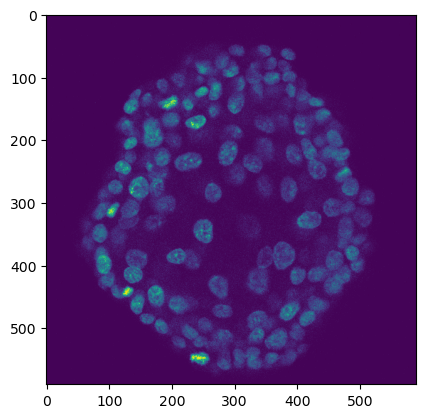

In [2]:
image = "https://github.com/StRigaud/pyopencl_clahe/raw/refs/heads/main/Test_image/TOrg2%20DAPI-1.tif"
raw = imread(image)
plt.imshow(raw[12])
plt.show()

## CLAHE doc and usage

In [6]:
cle.__experimental__.clahe?

Signature:
cle.__experimental__.clahe(
    input_image: Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array],
    output_image: Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array, NoneType] = None,
    tile_size: int = 8,
    clip_limit: float = 0.01,
    minimum_intensity: Optional[float] = None,
    maximum_intensity: Optional[float] = None,
    device: Optional[pyclesperanto._pyclesperanto._Device] = None,
) -> Union[numpy.ndarray, pyclesperanto._pyclesperanto._Array]
Docstring:
Contrast Limited Adaptive Histogram Equalization (CLAHE) is a method to enhance the contrast of images by
normalizing the intensity values in small regions of the image. This implementation is based on the OpenCL
implementation by Hugo Raveton.

Current implementation only supports 8-bit images.

Parameters
----------
input_image : Image
    The input image to be processed.
output_image : Image, optional
    The output image where the result will be stored. If None, a new image will be created.
ti

In [3]:
results_gpu = cle.__experimental__.clahe(raw, tile_size=8, clip_limit=0.01)cle.__experimental__.clahe

### Let's compare the output

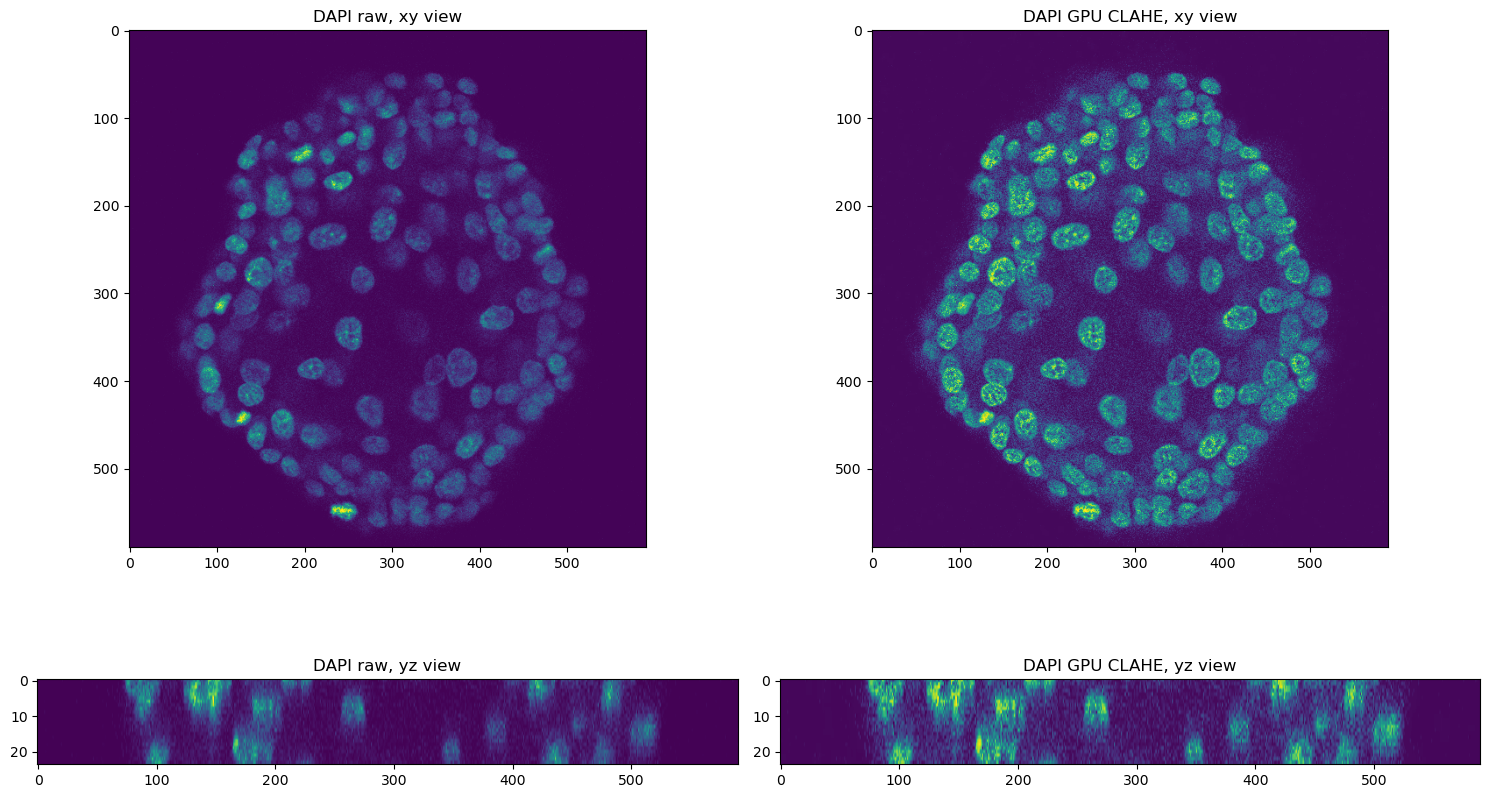

In [5]:
halfz = int(np.shape(raw)[0]/2)
halfx = int(np.shape(raw)[2]/2)

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0][0].imshow(raw[halfz])
axs[0][1].imshow(results_gpu[halfz])
axs[1][0].imshow(raw[:,halfx,:], aspect = 3)
axs[1][1].imshow(results_gpu[:,halfx,:], aspect = 3)
axs[0][0].set_title('DAPI raw, xy view')
axs[0][1].set_title('DAPI GPU CLAHE, xy view')
axs[1][0].set_title('DAPI raw, yz view')
axs[1][1].set_title('DAPI GPU CLAHE, yz view')
plt.tight_layout()
plt.show()